# PVInspect Defect Pipeline

This exemplarily demonstrates how several components from PVInspect can be combined to set up a complete defect analysis pipeline.

%load_ext autoreload
%autoreload 2

In [1]:
!git clone https://github.com/ma0ho/pvinspect.git
%cd pvinspect
!git checkout rework
!pip install .

Cloning into 'pvinspect'...
remote: Enumerating objects: 2487, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2487 (delta 3), reused 8 (delta 3), pack-reused 2477
Receiving objects: 100% (2487/2487), 25.06 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (1680/1680), done.
Updating files: 100% (56/56), done.
/home/mhoffmann/dev/pvinspect/examples/pvinspect


/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Branch 'rework' set up to track remote branch 'rework' from 'origin'.
Switched to a new branch 'rework'
Processing /home/mhoffmann/dev/pvinspect/examples/pvinspect
  Preparing metadata (setup.py) ... done
  Created wheel for pvinspect: filename=pvinspect-0.4.1-py3-none-any.whl size=99577 sha256=650a1245cbd76028d1be695469d3581cb8d55bbb1bedf411ecb05542192ee42c
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3w3fjwe/wheels/49/fc/ca/9a2e6c5ba74d34245494ec87df0ef71013254aa4ef862a40a9
Successfully built pvinspect
  Attempting uninstall: pvinspect
    Found existing installation: pvinspect 0.4.1
    Uninstalling pvinspect-0.4.1:
      Successfully uninstalled pvinspect-0.4.1


The `analysis` module requires `pytorch_lightning` and `albumentations` to be installed:

In [1]:
!pip install --upgrade pytorch_lightning albumentations>1.0

In [2]:
import pvinspect as pv
from pvinspect import preproc
from pathlib import Path
from pvinspect import analysis

/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/pvinspect/data/image/show_plugin.py:38: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


For this example, we've prepared a single image showing two modules at once. We now want to locate the modules, segment them into cells and run our a weakly supervised defect detection on the resulting cell images.

Let's get started and download the sample image:

In [3]:
!gdown --id 1kJPYct8AqmgzV1xIBWX47NnfTCtut4eJ

/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kJPYct8AqmgzV1xIBWX47NnfTCtut4eJ
To: /home/mhoffmann/dev/pvinspect/examples/multi_example.tif
100%|██████████████████████████████████████| 2.07M/2.07M [00:00<00:00, 61.0MB/s]


In [4]:
img = pv.data.io.read_image(Path("multi_example.tif"))

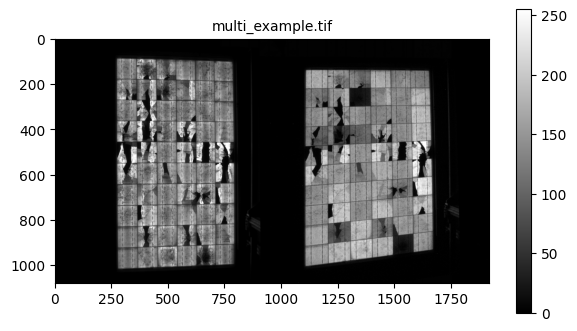

In [5]:
img.show(figscale=7)

## Multi module detection

Next, we run the built-in detection of multiple modules to coarsely locate the modules:

In [6]:
modules = preproc.detection.locate_multiple_modules(img)

  0%|          | 0/1 [00:00<?, ?it/s]/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/pvinspect/data/image/image.py:274: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for k, v in meta.iteritems():
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/pvinspect/data/image/image.py:274: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for k, v in meta.iteritems():


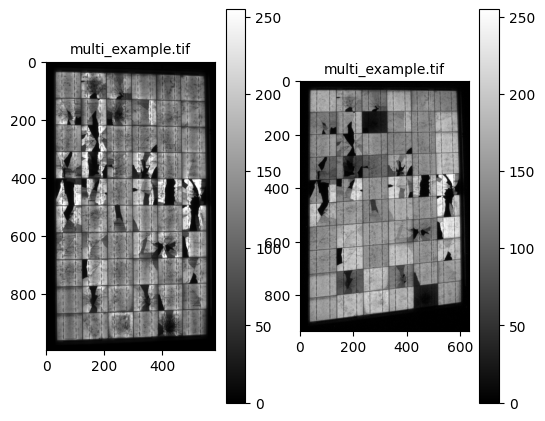

In [7]:
modules.head()

## Module segmentation

Before we can segment the module into single cells, we need to precisely locate the cell crossing points. Here we need to turn of the estimation of lens distortion, since this assumes that images come from the same camera and share a common lens distorion. This does not hold, since the module images are cropped out of a larger image. If you're still interested in distortion correction, you may want to use the calibration and compensation methods available in the `pvinspect.preproc.calibration` package.

In [8]:
modules = preproc.detection.locate_module_and_cells(modules, rows=6, cols=10, estimate_distortion=False)

  0%|          | 0/2 [00:00<?, ?it/s]/home/mhoffmann/dev/pvinspect/.venv/lib/python3.10/site-packages/pvinspect/common/util.py:76: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  is_inlier = np.zeros(n_samples, dtype=np.bool)
  0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

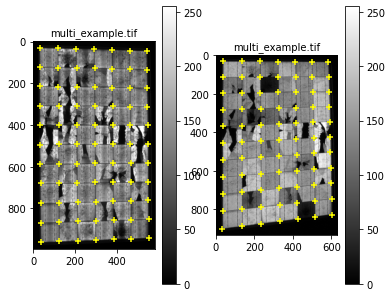

In [ ]:
modules.head()

With the cell crossing points detected, we're now able to segment the modules into single cells:

In [ ]:
cells = preproc.detection.segment_cells(modules)
len(cells)

  0%|          | 0/2 [00:00<?, ?it/s]

120

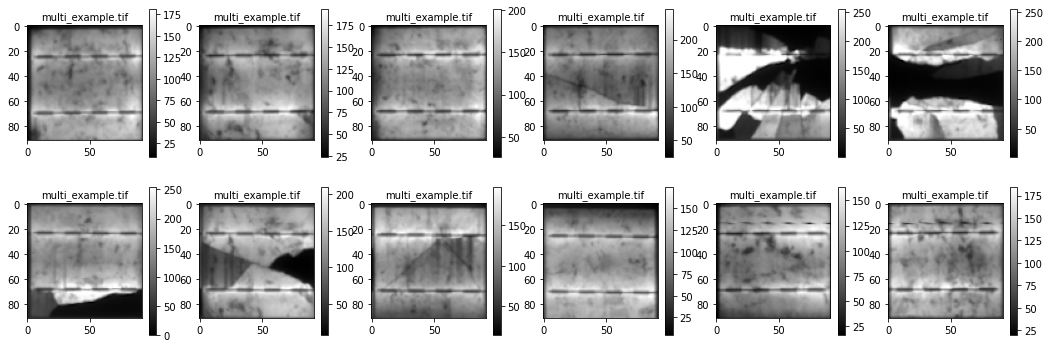

In [ ]:
cells.head(N=12, cols=6)

## Defect detection

For defect detection, we first load the model that comes pretrained with the toolbox. Note that it may be necessary to fine-tune the module for a new dataset, especially when a new module type is introduced that has not been present during training.

In [ ]:
model = analysis.factory_models.defects(use_cuda=True)

Now, we can directly apply the model to the cell images:

In [ ]:
cells = model.apply(cells)

  0%|          | 0/120 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


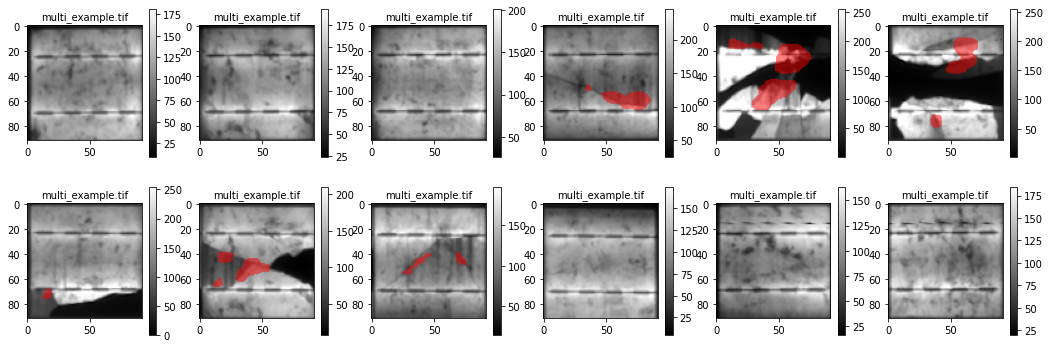

In [ ]:
cells.head(N=12, cols=6)

This gives possible defective areas as an overlay. For this data, it works to some extend, although it misses parts of the defective area. The results are also stored in the meta data:

In [ ]:
cells.meta.head()

,original_filename,multimodule_original,transform,rows,cols,first_col,first_row,segment_module_original,row,col,pred_crack_p,pred_inactive_p,pred_crack_cam,pred_inactive_cam
0,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,0,0,<pvinspect.data.image.image.EagerImage object ...,0,0,0.006425,0.000882,"[[0.00011856018, 5.398127e-05, 9.374277e-05, 6...","[[3.70417e-05, 1.1692902e-05, 1.4411654e-05, 2..."
1,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,1,0,<pvinspect.data.image.image.EagerImage object ...,0,1,0.003814,0.000227,"[[0.00019096679, 9.6984e-05, 0.00016218571, 0....","[[6.023582e-05, 1.6884356e-05, 3.535733e-05, 5..."
2,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,2,0,<pvinspect.data.image.image.EagerImage object ...,0,2,0.010952,0.000277,"[[0.00016819539, 6.3603235e-05, 0.00011126367,...","[[5.7032215e-05, 6.8024233e-06, 1.6822189e-05,..."
3,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,3,0,<pvinspect.data.image.image.EagerImage object ...,0,3,0.999749,0.000198,"[[3.700533e-05, 5.1692867e-05, 8.392847e-05, 6...","[[1.3225169e-05, 8.69966e-06, 7.850132e-06, 7...."
4,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,4,0,<pvinspect.data.image.image.EagerImage object ...,0,4,1.000000,0.999999,"[[0.00018646778, 3.200207e-05, 2.511929e-05, 2...","[[2.9509974e-05, 2.8185682e-06, 3.5304424e-06,..."


For example, we can now filter by the crack probability:

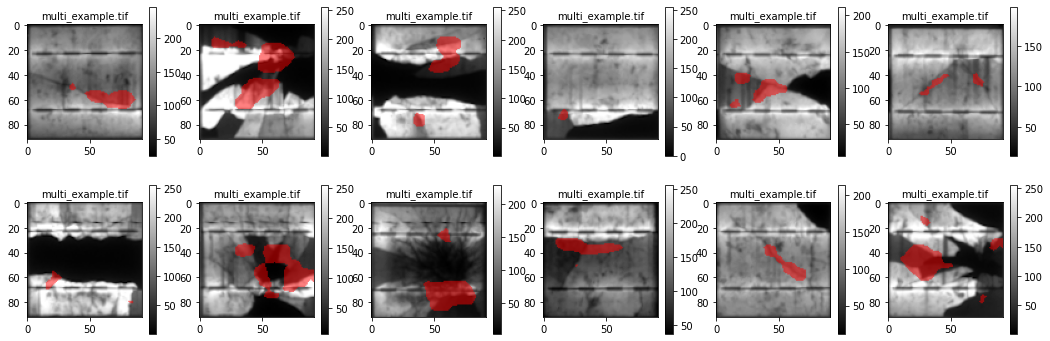

In [ ]:
cells.pandas.query("pred_crack_p > 0.5").head(N=12, cols=6)

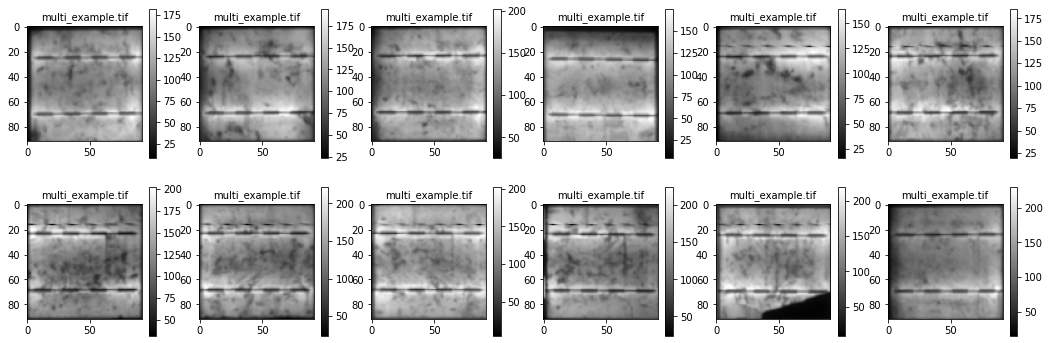

In [ ]:
cells.pandas.query("pred_crack_p < 0.5").head(N=12, cols=6)

## Analysis

Through the built-in meta data, PVInspect also keeps track of what has happend to a certain image. Let's for example, pick some image with a crack found:

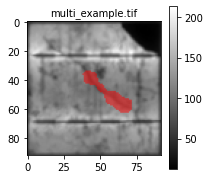

In [ ]:
example_cell = cells.pandas.query("pred_crack_p > 0.5")[10]
example_cell.show()

From the multimodule detection, we have the image this module originates from available through the `multimodule_original` meta property:

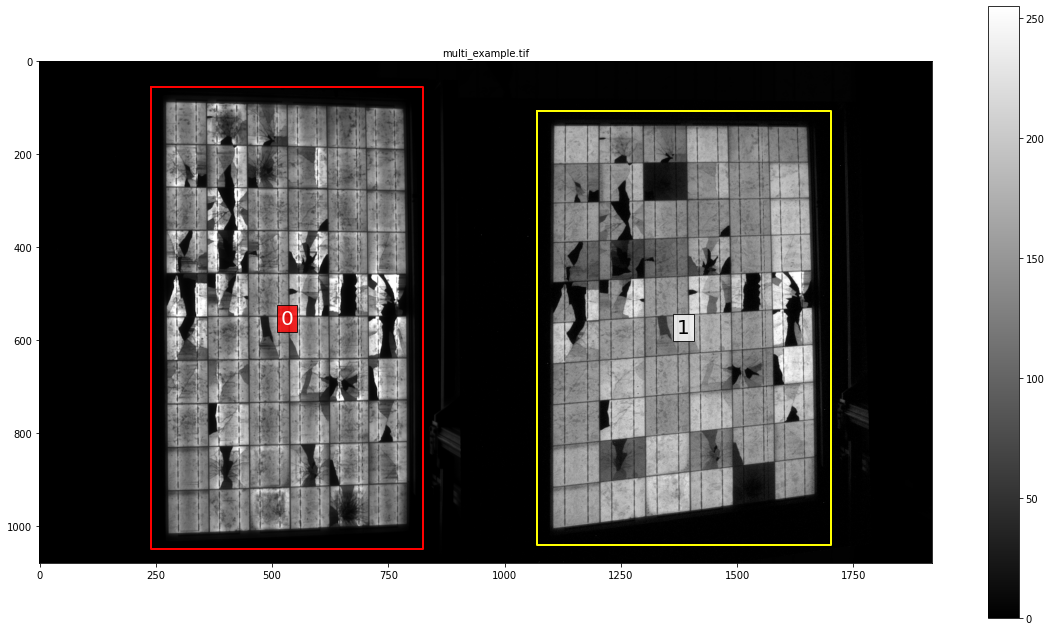

In [ ]:
example_cell.get_meta("multimodule_original").show(figscale=20)

Furthermore, from the cell segmentation, we have the row and column index:

In [ ]:
[example_cell.get_meta("row"), example_cell.get_meta("col")]

[2, 2]

Since the module detection asserts modules to be horizontally aligned (we specified that it has 10 columns, not rows!), we know that the cell at `(0, 0)` is the one on the top right of the left module image (highlighted in red). Thus, we can easily find the corresponding cell to `example_cell` in the module image.